Time Series RNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [121]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [122]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [125]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd204d02fd0>],
      dtype=object)

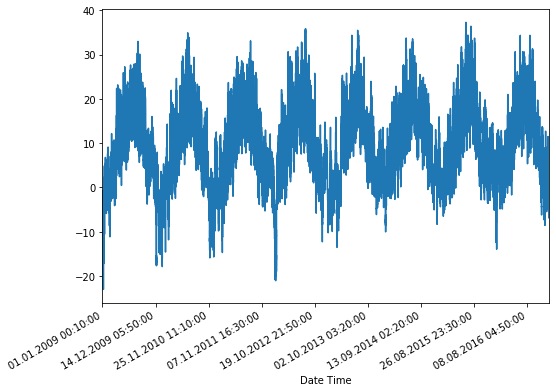

In [126]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [130]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.998]
 [-2.043]
 [-2.054]
 [-2.031]
 [-2.027]
 [-2.001]
 [-1.951]
 [-1.951]
 [-1.985]
 [-2.045]
 [-2.083]
 [-2.097]
 [-2.094]
 [-2.091]
 [-2.072]
 [-2.072]
 [-2.076]
 [-2.089]
 [-2.093]
 [-2.104]]

 Target temperature to predict
-2.1041848598100876


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

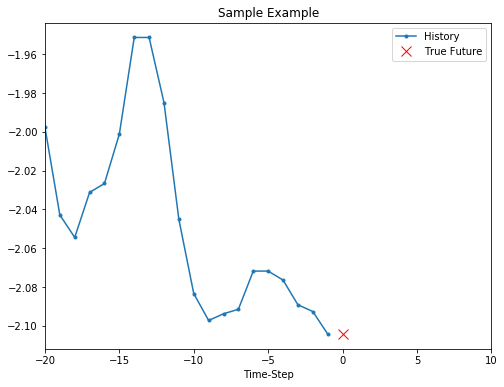

In [133]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

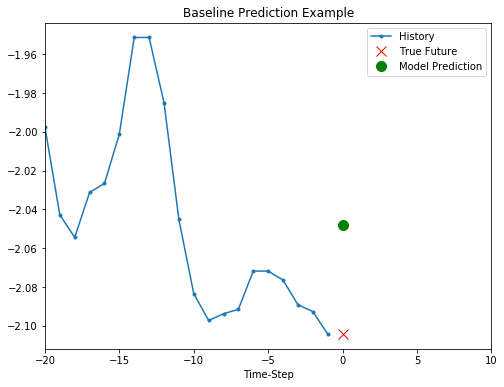

In [135]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [138]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [139]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [===========================

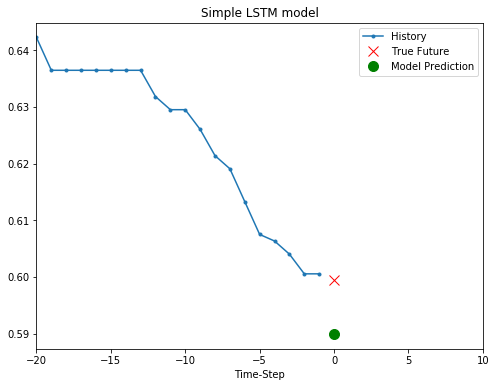

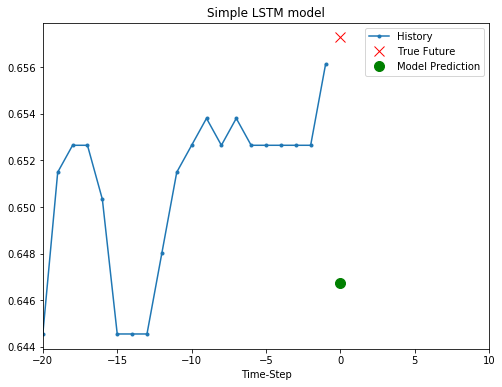

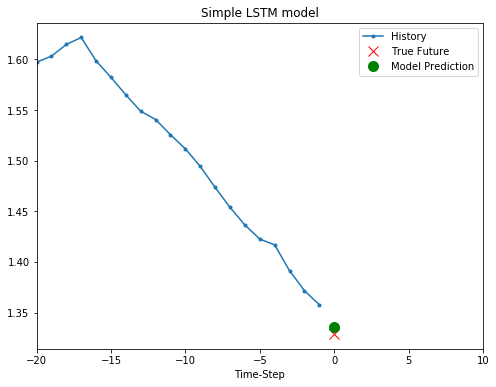

In [140]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [142]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd207df80f0>,
      dtype=object)

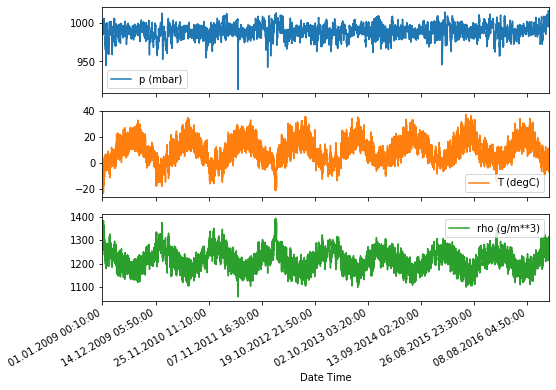

In [143]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [147]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [151]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [152]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 130ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 24s 118ms/step - loss: 0.2623 - val_loss: 0.2431
Epoch 3/10
200/200 [==============================] - 24s 119ms/step - loss: 0.2611 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 24s 122ms/step - loss: 0.2568 - val_loss: 0.2449
Epoch 5/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2262 - val_loss: 0.2348
Epoch 6/10
200/200 [==============================] - 24s 119ms/step - loss: 0.2414 - val_loss: 0.2680
Epoch 7/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2408 - val_loss: 0.2567
Epoch 8/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2401 - val_loss: 0.2380
Epoch 9/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2453 - val_loss: 0.2469
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

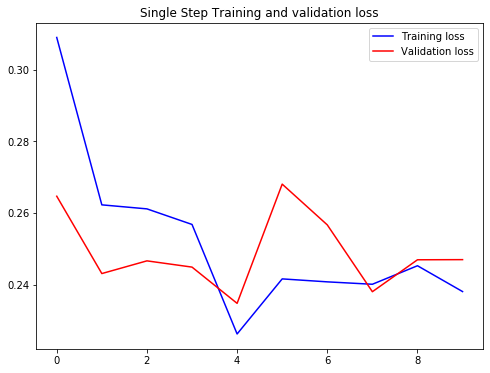

In [154]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

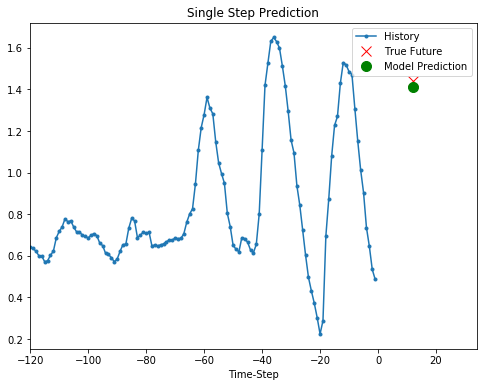

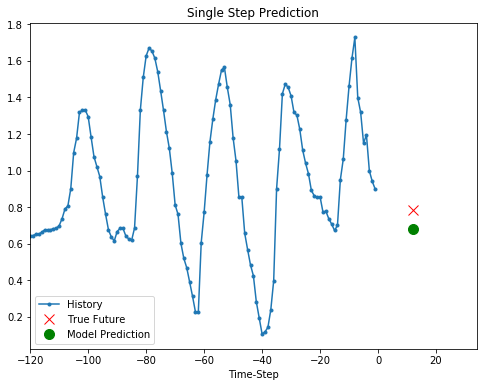

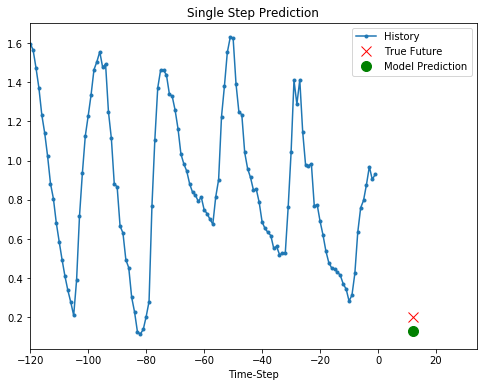

In [155]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [157]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

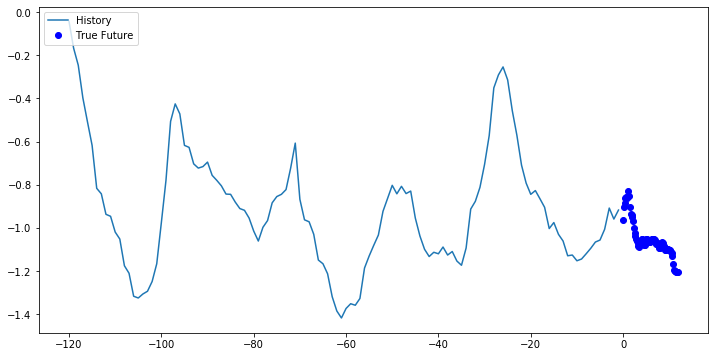

In [160]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [162]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [163]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 44s 218ms/step - loss: 0.4960 - val_loss: 0.3072
Epoch 2/10
200/200 [==============================] - 43s 213ms/step - loss: 0.3470 - val_loss: 0.2905
Epoch 3/10
200/200 [==============================] - 45s 227ms/step - loss: 0.3297 - val_loss: 0.2527
Epoch 4/10
200/200 [==============================] - 44s 221ms/step - loss: 0.2430 - val_loss: 0.2038
Epoch 5/10
200/200 [==============================] - 43s 213ms/step - loss: 0.1973 - val_loss: 0.1979
Epoch 6/10
200/200 [==============================] - 44s 219ms/step - loss: 0.2060 - val_loss: 0.2107
Epoch 7/10
200/200 [==============================] - 47s 235ms/step - loss: 0.1978 - val_loss: 0.2070
Epoch 8/10
200/200 [==============================] - 47s 237ms/step - loss: 0.1963 - val_loss: 0.1962
Epoch 9/10
200/200 [==============================] - 47s 236ms/step - loss: 0.1982 - val_loss: 0.1849
Epoch 10/10
200/200 [=========

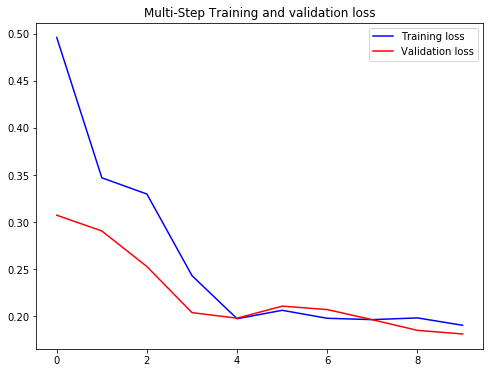

In [164]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

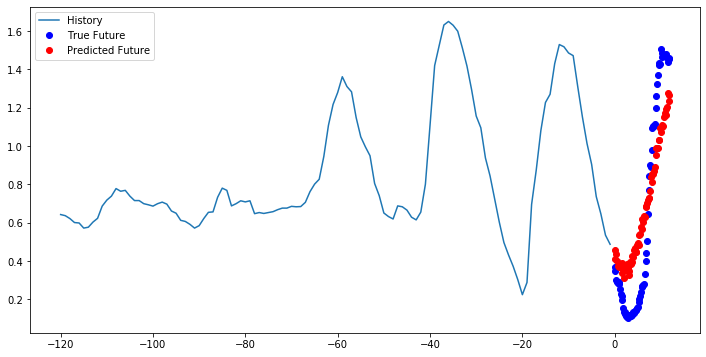

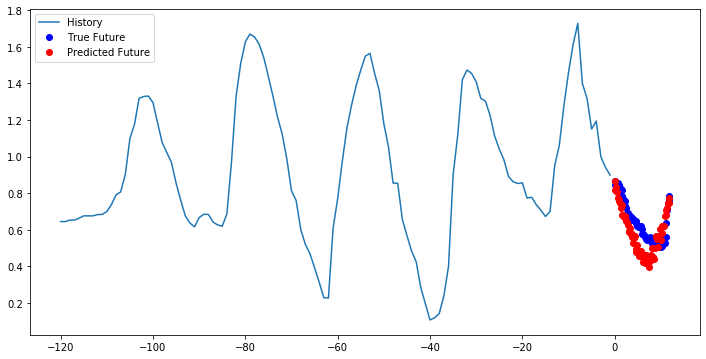

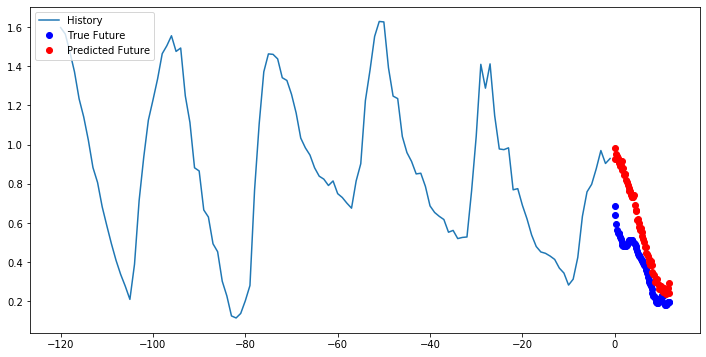

In [165]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Text Classification RNN

In [0]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [173]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features['text'].encoder

In [175]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [176]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [178]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [179]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

AttributeError: ignored

Keras Distribute

In [180]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

import os

     |████████████████████████████████| 380.5MB 37kB/s 
     |████████████████████████████████| 501kB 45.6MB/s 
     |████████████████████████████████| 4.3MB 44.2MB/s 
ERROR: tf-nightly 2.1.0.dev20191227 has requirement tb-nightly<2.3.0a0,>=2.2.0a0, but you'll have tb-nightly 1.15.0a20190806 which is incompatible.
  Found existing installation: tf-estimator-nightly 2.0.0.dev2019122709
    Uninstalling tf-estimator-nightly-2.0.0.dev2019122709:
      Successfully uninstalled tf-estimator-nightly-2.0.0.dev2019122709
  Found existing installation: tb-nightly 2.2.0a20191227
    Uninstalling tb-nightly-2.2.0a20191227:
      Successfully uninstalled tb-nightly-2.2.0a20191227


In [181]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


In [182]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [183]:
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

장치의 수: 1


In [0]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [0]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

In [0]:
train_dataset = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

In [0]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [0]:
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [0]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\n에포크 {}의 학습률은 {}입니다.'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [0]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [192]:
model.fit(train_dataset, epochs=12, callbacks=callbacks)

Epoch 1/12
    938/Unknown - 41s 44ms/step - loss: 0.1976 - accuracy: 0.9435
에포크 1의 학습률은 0.0010000000474974513입니다.
938/938 [==============================] - 41s 44ms/step - loss: 0.1976 - accuracy: 0.9435
Epoch 2/12
937/938 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9801
에포크 2의 학습률은 0.0010000000474974513입니다.
938/938 [==============================] - 37s 39ms/step - loss: 0.0657 - accuracy: 0.9801
Epoch 3/12
937/938 [============================>.] - ETA: 0s - loss: 0.0458 - accuracy: 0.9859
에포크 3의 학습률은 0.0010000000474974513입니다.
938/938 [==============================] - 37s 39ms/step - loss: 0.0457 - accuracy: 0.9859
Epoch 4/12
937/938 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9931
에포크 4의 학습률은 9.999999747378752e-05입니다.
938/938 [==============================] - 36s 39ms/step - loss: 0.0253 - accuracy: 0.9931
Epoch 5/12
937/938 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9940
에포크 5의 학습률은 9.999999747

In [193]:
!ls {checkpoint_dir}

checkpoint		     ckpt_4.data-00000-of-00001
ckpt_10.data-00000-of-00001  ckpt_4.index
ckpt_10.index		     ckpt_5.data-00000-of-00001
ckpt_11.data-00000-of-00001  ckpt_5.index
ckpt_11.index		     ckpt_6.data-00000-of-00001
ckpt_12.data-00000-of-00001  ckpt_6.index
ckpt_12.index		     ckpt_7.data-00000-of-00001
ckpt_1.data-00000-of-00001   ckpt_7.index
ckpt_1.index		     ckpt_8.data-00000-of-00001
ckpt_2.data-00000-of-00001   ckpt_8.index
ckpt_2.index		     ckpt_9.data-00000-of-00001
ckpt_3.data-00000-of-00001   ckpt_9.index
ckpt_3.index


In [194]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(eval_dataset)

print('평가 손실: {}, 평가 정확도: {}'.format(eval_loss, eval_acc))

    157/Unknown - 5s 31ms/step - loss: 0.0379 - accuracy: 0.9872평가 손실: 0.03794536099006914, 평가 정확도: 0.9872000217437744


In [195]:
!ls -sh ./logs

total 4.0K
4.0K train


In [196]:
path = 'saved_model/'
tf.keras.experimental.export_saved_model(model, path)

AttributeError: ignored